In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
import time

In [2]:
## convert an input image to histogram

In [3]:
def img_to_hist(f, mode=True):
    """
    Converts an input image to histogram.
    @Param:
    1. f - np.array list for input image.
    2. mode - (boolean) normalize the output? default = true
    @Return
    2. hist - list for histogram (use plt.plot(hist)) for displaying the histogram
    """
    row, col = f.shape #get number of rows and columns
    hist = np.zeros(256) #reference list for calculating the frequency
    
    for i in range(row): #get row
        for j in range(col): #get column
            intensity = f[i][j] #get current pixel
            hist[intensity] += 1
    
    if(mode): #normalize the image
        hist /= row*col
    return hist #normalize to probabilities 

In [4]:
input_image = np.array(Image.open('hidden-symbols.tif'))

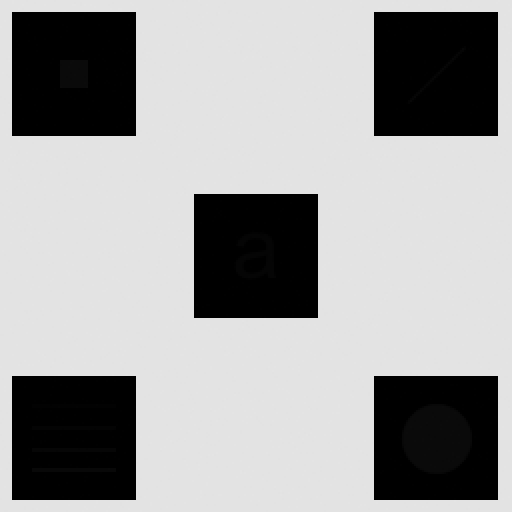

In [5]:
Image.fromarray(input_image)

In [6]:
histogram = img_to_hist(input_image, True)

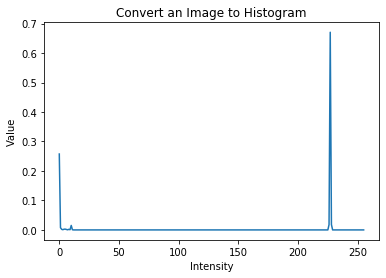

In [7]:
plt.title("Convert an Image to Histogram")
plt.xlabel("Intensity")
plt.ylabel("Value")
plt.plot(histogram)
plt.show()

In [8]:
## Histogram Equalization

In [9]:
# steps:
# 1. replicate padding. DONE
# 2. compute pdf. DONE
# 3. compute cdf. DONE
# 4. find the middle element and replace with the round(cdf) value. DONE
# 5. return new matrix without the replicate padding. DONE

In [10]:
def replicate_padding(arr):
    """Perform replicate padding on a numpy array."""
    new_pad_shape = tuple(np.array(arr.shape) + 2)
    padded_array = np.zeros(new_pad_shape) #create an array of zeros with new dimensions
    
    # perform replication
    padded_array[1:-1,1:-1] = arr        # result will be zero-pad
    padded_array[0,1:-1] = arr[0]        # perform edge pad for top row
    padded_array[-1, 1:-1] = arr[-1]     # edge pad for bottom row
    padded_array.T[0, 1:-1] = arr.T[0]   # edge pad for first column
    padded_array.T[-1, 1:-1] = arr.T[-1] # edge pad for last column
    
    #at this point, all values except for the 4 corners should have been replicated
    padded_array[0][0] = arr[0][0]     # top left corner
    padded_array[-1][0] = arr[-1][0]   # bottom left corner
    padded_array[0][-1] = arr[0][-1]   # top right corner 
    padded_array[-1][-1] = arr[-1][-1] # bottom right corner

    return padded_array

In [11]:
def get_slices(arr, width, height):
    """Collects m (width) x n (height) slices for a padded array"""
    row, col = 0, 0
    slices = []
    for i in range(len(arr) - width + 1): #get row
        for j in range(len(arr[i]) - height + 1): #get column
            r = i + width
            c = j + height
            sub_array = arr[i:r, j:c]
            slices.append(sub_array)
    return np.array(slices)

In [12]:
def pdf(sub_array, m, n):
    """
    --- HELPER METHOD ---
    
    Computes the pdf of portion of an array, indicated by sub_array
    @Param:
    1. sub_array - m * n array
    2. m - integer value for number of rows in the sub array.
    3. n - integer value for number of columns in the sub array.
    @Return
    - values : overall distribution as probability
    """
    values = {} #dictionary for counter
    fraction = 1/(m*n) #iterative fraction
    
    for i in range(m): #get row
        for j in range(n): #get column
            intensity = sub_array[i][j]
            if(intensity in values):
                values[intensity] += fraction
            else:
                values[intensity] = fraction  
           
    _, prob = zip(*list(values.items()))
    assert(np.round(sum(prob), decimals=6) == 1.0) #assert ∑ pdf = 1 
    
    return dict(OrderedDict(sorted(values.items())))

In [13]:
def cdf_value(pdf_dict, range_L, value):
    """
    --- HELPER METHOD ---
    
    Calculate the Cumultive Density Function (cdf) for a particular value
    based on its Probability Density Function (pdf) values.
    @Param:
    1. pdf_dict - dictionary of {intensity:probability} mapping
    2. range_L - overall range, L - 1 (const)
    @Returns
    - cdf: (float) cumulitive density function value based on 
    """
    cdf = 0
    count, prob = zip(*list(pdf_dict.items())) #unwrap
    for c, x in zip(count, prob):
        cdf += x*range_L 
        if(c == value):
            break
    return round(cdf)

In [14]:
def replace_value(sub_array, range_L):
    """Finds the middle value of the array and returns the CDF calculated value"""
    m, n = sub_array.shape
    midpoint = round(m/n)
    value = sub_array[midpoint, midpoint] #find the midpoint
    pdf_dict = pdf(sub_array, m, n)
    cdf = cdf_value(pdf_dict, range_L, value) #calculate the desired cdf
    return cdf

In [15]:
def localHistEqual4e(f, m, n):
    """
    Perform Local Histogram Equalization on a neighboring set of pixels.
    @Param:
    1. f - input image as an nd.array
    2. m - neighborhood width
    3. n - neighborhood height
    @Return
    - Transformation values on the original image, f as nd.array.
    """
    L = 255
    padded = replicate_padding(f)
    output_shape = tuple(np.array(padded.shape) - np.array([m, n]) + 1) #reshape later to this format
    sliced = get_slices(padded, m, n)
    outer = []
    for i, sub_array in enumerate(sliced):
        val = replace_value(sub_array, L)
        outer.append(np.uint8(val))

    return np.reshape(outer, output_shape)

In [16]:
start = time.time()
output = localHistEqual4e(input_image, 7, 7)
stop = time.time()
print(f"Total time taken: {np.round(stop - start, decimals=3)} seconds")

Total time taken: 10.311 seconds


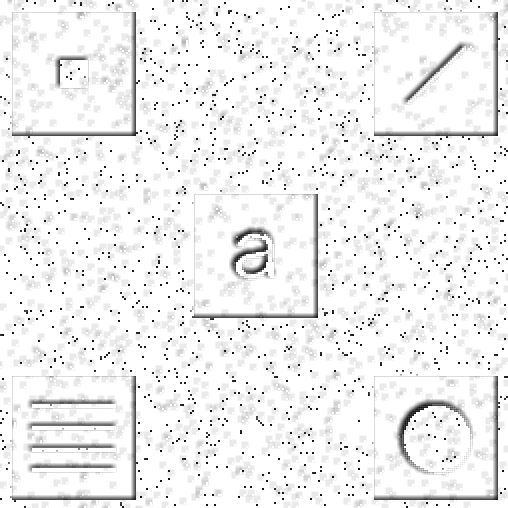

In [17]:
#visualize output image
Image.fromarray(output)

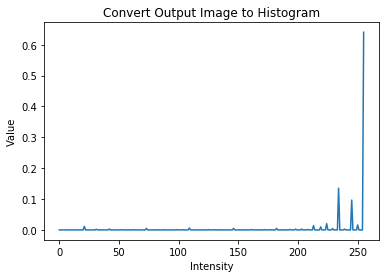

In [18]:
#Plot histogram for output value
histogram = img_to_hist(output, True)
plt.title("Convert Output Image to Histogram")
plt.xlabel("Intensity")
plt.ylabel("Value")
plt.plot(histogram)
plt.show()

In [19]:
#end.